In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [4]:
# Read CSV file using pandas
credits = pd.read_csv('datasets/tmdb_5000_credits.csv')
movies =  pd.read_csv('datasets/tmdb_5000_movies.csv')
credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [6]:
#Merge tables on "id"
credits.columns = ['id','title','cast','crew']
movies = movies.merge(credits,on='id')

In [7]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,tagline,title_x,vote_average,vote_count,title_y,cast_x,crew_x,title,cast_y,crew_y
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [8]:
j = json.loads(movies.iloc[0]['genres'])
j

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [9]:
#Merge words
' '.join(''.join(jj['name'].split()) for jj in j)

'Action Adventure Fantasy ScienceFiction'

In [39]:
def genres_keywords_to_string(row):
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(j['name'].split()) for j in genres)
    
    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
    return "%s" % (genres)

In [40]:
#apply() applies a function to the dataframe
#create string collumn
movies['string'] = movies.apply(genres_keywords_to_string, axis=1)

In [42]:
#Create tfidf and fit 
#Keeps the most frequent terms, up to 2000 collumns
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(movies['string'])

In [43]:
X

<4803x20 sparse matrix of type '<class 'numpy.float64'>'
	with 12160 stored elements in Compressed Sparse Row format>

In [44]:
#generate mapping from movie title -> index (in df)
movie2idx = pd.Series(movies.index, index=movies['original_title'])
movie2idx

original_title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [45]:
idx = movie2idx['Avatar']
idx

0

In [46]:
query = X[idx]
query

<1x20 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [47]:
#print query vector
query.toarray()
#compute similarity between query and every vector in X
scores = cosine_similarity(query,X)
scores.shape

(1, 4803)

(4803,)


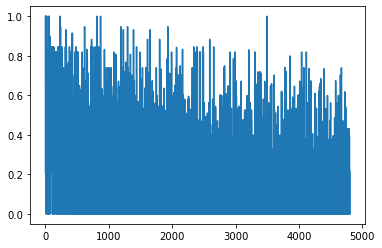

In [49]:
scores = scores.flatten()
print(scores.shape)
plt.plot(scores)

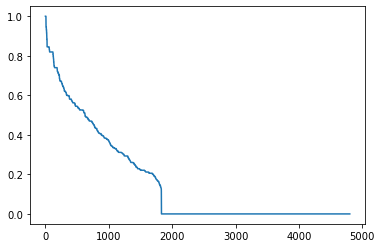

In [50]:
#sort in descenting order
(-scores).argsort()
plt.plot(scores[(-scores).argsort()])

In [51]:
print((-scores).argsort())

[   0 3494   46 ... 2355 2397 4802]


In [52]:
#get top 5 matches, exclude self
recommended = (-scores).argsort()[1:6]
#convert them to titles again
movies['original_title'].iloc[recommended]

3494    Beastmaster 2: Through the Portal of Time
46                     X-Men: Days of Future Past
813                                      Superman
870                                   Superman II
14                                   Man of Steel
Name: original_title, dtype: object

In [29]:
#make it a function
def recommend_movie(title):
    idx = movie2idx[title]
    if type(idx) == pd.Series:
        idx = idx.iloc[0]
    query = X[idx]
    scores = cosine_similarity(query,X)
    scores = scores.flatten()
    recommended = (-scores).argsort()[1:6]

    return movies['original_title'].iloc[recommended]


In [30]:
recommend_movie('The Dark Knight Rises')

65      The Dark Knight
119       Batman Begins
2864          Arbitrage
1359             Batman
210      Batman & Robin
Name: original_title, dtype: object